## Load necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import time, copy

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from sklearn.metrics import accuracy_score, f1_score

# setting random seeds for reproducibility of results
torch.manual_seed(0)
np.random.seed(0)


## Load and transform a dataset

__MNIST__ dataset contains images of 0 to 9 handwritten digits.
__FashionMNIST__ dataset contains images of ten (labeled 0 to 9) different clothing categories: T-shirts/tops, trousers, pullovers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots.

In [2]:

img_HW = 16            
d = img_HW**2   

print(f'image Hight = image Width = {img_HW}')
print(f'img_HW**2 = dimension of the Hilbert space = d = {d} \n')


#================================================================================================


transform = transforms.Compose([ 
    transforms.Resize((img_HW, img_HW)),                          # resize image 
    transforms.ToTensor(),                                        # to transform an image into a tensor
    transforms.Normalize(mean=(0.5,), std=(0.5,))                 # to put all the pixel values between -1 and 1
])



def load_dataset(name):
    print(name,'\n')
    if name == "FashionMNIST":
        train_dataset = datasets.FashionMNIST(root="/home/FashionMNIST", 
                                              train=True, download=True, transform=transform)
        test_dataset = datasets.FashionMNIST(root="/home/FashionMNIST", 
                                             train=False, download=True, transform=transform)
    elif name == "MNIST":
        train_dataset = datasets.MNIST(root="/home/MNIST", 
                                       train=True, download=True, transform=transform)
        test_dataset = datasets.MNIST(root="/home/MNIST", 
                                      train=False, download=True, transform=transform)
    return train_dataset, test_dataset 


#================================================================================================


whole_train_dataset, whole_test_dataset = load_dataset("MNIST")   # Choose either "MNIST" or "FashionMNIST"



image Hight = image Width = 16
img_HW**2 = dimension of the Hilbert space = d = 256 

MNIST 



## Define Quantum Machine Learning (QML) model : Interferometric Neural Network (INN)

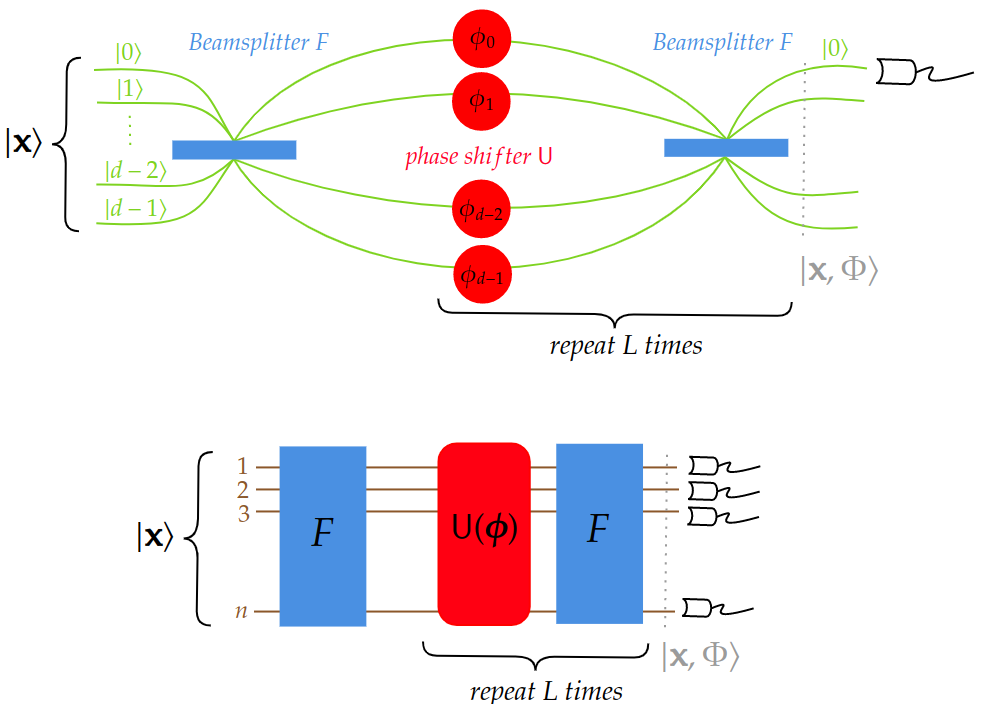


Beamsplitter (the discrete Fourier transformation)
$F = \frac{1}{\sqrt{d}}\sum_{k=0}^{d-1} \sum_{j=0}^{d-1} \omega^{\,kj}\,|k \rangle\langle j|$, where ${\omega=\text{e}^{\texttt{i}\frac{2\pi}{d}}}$ is a $d$th root of unity.

phase shifter
$U(\boldsymbol{\phi}) = \sum_{j=0}^{d-1}  \text{e}^{\texttt{i}\phi_j}|j \rangle\langle j|$


__Amplitude encodings__ of data (images):
An input state $|\textbf{x}\rangle  = \frac{1}{\|\textbf{x}\|}\sum_{j=0}^{d-1}  x_j\,|j \rangle$
carries normalixed pixel values of an image in its amplitudes.
$\|\textbf{x}\|$ is the Euclidean norm of the feature vector $\textbf{x}$ made after flattening a image.


The output from the last interferometer is
$ |\textbf{x}, \Phi \rangle  = \left(\prod_{l=1}^{L} F U(\boldsymbol{\phi}^{l}) \right) F\, |\textbf{x}\rangle$
and $p = |\langle 0|\textbf{x}, \Phi \rangle|^2$
is the probability of getting $0$th outcome (that is, detecting quantum particles in the $0$th path). 
For binary classification, one can interpret $p$ as the probability of a data point belonging to the positive class ($c=1$) and $1-p$ as the probability of it belonging to the negative class ($c=1$). All the learnable parameters are denoted by 
$\Phi=(\boldsymbol{\phi}^1,\cdots,\boldsymbol{\phi}^L)\in\mathbb{R}^{L\times d}$, which carries $L$ phase-vectors
$\boldsymbol{\phi}=(\phi_0,\cdots,\phi_{d-1})\in\mathbb{R}^d$, one for each interferometer.

$ $

In [3]:
class Interferometer(nn.Module):
    def __init__(self, d):
        super(Interferometer, self).__init__()
        
        self.d = d                                             # dimension of the Hilbert space
        
        torch.manual_seed(1)                         # setting a specific seed for reproducibility of results                                          
        phases = torch.empty((1, d), dtype=torch.float)        # Initialize learnable phases
        nn.init.xavier_uniform_(phases)     
        self.phases = nn.Parameter(phases) 
        
        
    def forward(self, x):                          # x.shape = (batch_size, d)
        x = x * torch.exp(1j * self.phases)        # Perform the phase shifter
        x = torch.fft.fft(x, norm='ortho')         # Perform 1D Fast Fourier Transform (beamsplitter)
        return x                                   # x.shape = (batch_size, d)

    
#================================================================================================

'''Here, INN is a sequence L Interferometers'''

class INN(nn.Module):                                      
    def __init__(self, d, L):                 
        super(INN, self).__init__()
        
        
        self.d = d                                             # dimension of the Hilbert space
        self.L = L                                             # number of quantum layers
        
        self.phase_filters_layers = nn.ModuleList([Interferometer(d) for _ in range(L)])
        
        
    def forward(self, x):
        x = x.view(-1, self.d)

        x = F.normalize(x, dim=-1)           # amplitude encodings  x -->  |x>
        
        #------------------------------------------------------------------------------------ 
        
        x = torch.fft.fft(x, norm='ortho')   # First ID Fast Fourier Transforms (beamsplitters)
        
        for phase_filters in self.phase_filters_layers:
            x = phase_filters(x)
            
         #------------------------------------------------------------------------------------
            
        x = x*(x.conj())                     # measurement in the computational basis and getting probabilities 
        x = torch.real(x)                    # dropping the imaginary components 0j

        x = x[:,0]                           # probability of getting 0 outcome
    
        return x 



## Define training loop and performance evaluation function

In [4]:

def training_loop(dataloader, epochs):
    model = INN(d=d, L=L).to(device)                                           # start the QML model instance
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(b1, b2))    # define optimizer for the model
    loss_fn = nn.BCELoss()                                                  # define loss functions for the model
    
    for t in range(epochs):
        for batch_idx, (X, y) in enumerate(dataloader):
            
            X, y = X.to(device), y.to(torch.float32).to(device)
            
            out = model(X)                            # Perform a single forward pass through the model, out = p(Φ)
            loss = loss_fn(out, y)
            model.zero_grad()                         # Clear gradients 
            loss.backward(retain_graph=True)          # Derive gradients, backpropagation 
            optimizer.step()                          # Update parameters of the model based on gradients
            
    model_state_dict = model.state_dict()             # for saving or loading the trained model
    return model_state_dict

            
#================================================================================================


def performance_evaluation(dataset, model):
    data_size = len(dataset)
    
    dataloader = DataLoader(dataset=dataset, batch_size=data_size, shuffle=False)
    num_batches = len(dataloader)
    
    model.eval()
    loss, accuracy = 0, 0
    with torch.no_grad():
        ys, probs = torch.tensor([]), torch.tensor([]) 
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            ys = torch.cat((ys, y), 0)
            
            prob = model(X)
            probs = torch.cat((probs, prob), 0)
    
    # prob <= threshold: predicted class c=0
    # prob >  threshold: predicted class c=1, here threshold = 0.5
    
    y_predicted = torch.heaviside(prob-0.5, torch.tensor(0.)) 
            
    accuracy = accuracy_score(ys, y_predicted)
    f1 = f1_score(ys, y_predicted)
    return accuracy, f1

## Set device and hyperparameters

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_num_threads(1)                                # it is for reproducibility of results

#==================================================================

L = 2

print(f'image Hight = image Width = {img_HW}')
print(f'dimension of the Hilbert space = d = {d}')
print(f'number of quantum layers = L = {L}')

num_phases = L*d
print(f'number of learnable (parameters) phases in the model = {num_phases}\n')



#---------------------------------------------------------------
# optimizers' hyperparameters

lr = 1e-2

b1 = 0.5
b2 = 0.9

#==================================================================

batch_size = 2**6
epochs = 10


image Hight = image Width = 16
dimension of the Hilbert space = d = 256
number of quantum layers = L = 2
number of learnable (parameters) phases in the model = 512



## training and evaluation of binary image classification problems


To create a 2-class (binary) classification problem for the MNIST (or FashionMNIST) dataset, we gathered all the images of only two specific digits, denoted as $a$ and $b$, which are respectively labeled as the negative class $c=0$ and the positive class $c=1$. 

In [6]:
%%time

def generate_subset(dataset, a, b):
    subset = []
    for i in range(len(dataset)):
        x, y = dataset[i]
        if y==a:
            subset.append((x, torch.tensor(0., dtype=torch.float32)))   # every image of digit a labeled as 0
        elif y==b:
            subset.append((x, torch.tensor(1., dtype=torch.float32)))   # every image of digit b labeled as 1
    return subset



def classification_task(a, b):
    train_dataset = generate_subset(whole_train_dataset, a, b)      # data preparation of the two classes
    test_dataset = generate_subset(whole_test_dataset, a, b)
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    model_state_dict = training_loop(train_dataloader, epochs)      # training on the train set
    
    
    model = INN(d=d, L=L).to(device)                                # start the QML model instance
    model.load_state_dict(model_state_dict)                         # load the trained model parameters
    accuracy, f1 = performance_evaluation(test_dataset, model)      # its evaluation on the test set
    return accuracy, f1


#================================================================================================


total_classes = 10

ACC_mat = np.zeros((total_classes, total_classes))                 # initialization of ACC_mat and F1_mat
F1_mat = np.zeros((total_classes, total_classes))

for a in range(total_classes):
    for b in range(a+1, total_classes):
        accuracy, f1 = classification_task(a, b)
        ACC_mat[a, b] = accuracy
        F1_mat[a, b] = f1
        
        if b==a+1:
            print(f'digits (a, b) = {a, b}   accuracy = {accuracy:.2f}   f1 score = {f1:.2f}')
    
        accuracy, f1 = classification_task(b, a)
        ACC_mat[b, a] = accuracy
        F1_mat[b, a] = f1

        
print()
print(f' ~~~~~ its done ~~~~~\n')   


digits (a, b) = (0, 1)   accuracy = 0.99   f1 score = 0.99
digits (a, b) = (1, 2)   accuracy = 0.81   f1 score = 0.75
digits (a, b) = (2, 3)   accuracy = 0.93   f1 score = 0.93
digits (a, b) = (3, 4)   accuracy = 0.99   f1 score = 0.99
digits (a, b) = (4, 5)   accuracy = 0.91   f1 score = 0.89
digits (a, b) = (5, 6)   accuracy = 0.95   f1 score = 0.95
digits (a, b) = (6, 7)   accuracy = 0.98   f1 score = 0.98
digits (a, b) = (7, 8)   accuracy = 0.92   f1 score = 0.91
digits (a, b) = (8, 9)   accuracy = 0.94   f1 score = 0.94

 ~~~~~ its done ~~~~~

CPU times: user 18min 34s, sys: 77.1 ms, total: 18min 34s
Wall time: 18min 34s


## Save and plot the accuracy and F1 matrices

In [7]:
# np.save('ACC_mat.npy', ACC_mat)
# np.save('F1_mat.npy', F1_mat)

# np.load('ACC_mat.npy')

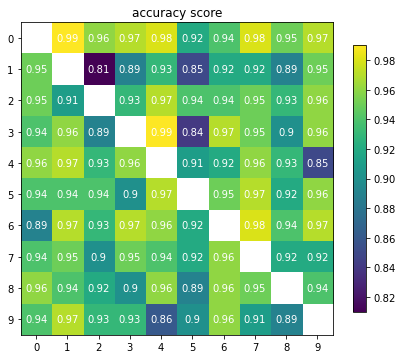

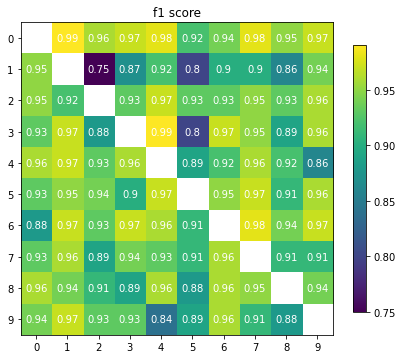

In [8]:
def plot(matrix, title):
    fig, ax = plt.subplots(figsize=(7,7))                 # Create a figure and axis
    cax = ax.imshow(matrix, cmap='viridis')               # Display the image using imshow
    
    for i in range(matrix.shape[0]):                      # Add text annotations with values
        for j in range(matrix.shape[1]):
            text = ax.text(j, i, matrix[i, j], ha='center', va='center', color='w')
            
    cbar = fig.colorbar(cax, shrink=0.7)                  # Add a colorbar to the right of the image
    ax.set_xticks(range(matrix.shape[0]))
    ax.set_yticks(range(matrix.shape[1]))
    ax.set_title(f'{title}')
    plt.show()                                            # Show the plot
    
#============================================================================


ACC_matrix = np.round(ACC_mat, 2)
F1_matrix = np.round(F1_mat, 2)
for i in range(total_classes):
    ACC_matrix[i,i]=None                                 # Setting the diagonal entries to None
    F1_matrix[i,i]=None
    


#============================================================================

plot(ACC_matrix, 'accuracy score')
plot(F1_matrix, 'f1 score')

# 

$ $